In [97]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

results_dir = '../../results/shuffle_experiment/default'

sns.set_theme(style="white")

def draw_checkpoint_line(ax, df_model_results, palette, linestyles):
    for idx_exp, experiment in enumerate(df_model_results['Experiment'].unique()):
        df_experiment = df_model_results[df_model_results['Experiment'] == experiment]
        df_experiment = df_experiment.sort_values(by='Experiment')

        ax.axvline(x=df_experiment['Epoch'].iloc[0], color=palette[idx_exp], linestyle=linestyles[idx_exp], linewidth=1)


def plot_loss_curves(df_losses, palette=sns.color_palette("tab10")):
    models = df_losses['Model'].unique()
    if len(models) == 0:
        raise ValueError("No models found in the DataFrame.")
    
    fig, ax = plt.subplots(ncols=2,nrows=len(models), figsize=(12, 6*len(models)), sharex=True, sharey=True)

    for idx, m in enumerate(models):
        df_model = df_losses[df_losses['Model'] == m]
        df_model = df_model.sort_values(by='Experiment')

        sns.lineplot(data=df_model, x='Epoch', y='train_loss', hue='Experiment', palette=palette, ax=ax[idx,0])
        sns.lineplot(data=df_model, x='Epoch', y='val_loss', hue='Experiment', palette=palette, ax=ax[idx,1])
        ax[idx, 0].set(title=f'Train Loss - {m}', ylabel='BCE Loss')
        ax[idx,1].set(title=f'Validation Loss - {m}')
                
    plt.tight_layout()
    
    return fig

def get_val_metric(task):
    if task == 'gene finding':
        return 'val_mcc', 'MCC'
    elif task == 'enhancer annotation':
        return 'val_auprc', 'AUPRC'
    return 'val_auroc', 'AUROC'

def plot_auroc_curves(df, df_results=None, palette=sns.color_palette("tab10"), linestyles = ['-.','--',':']):
    models = df['Model'].unique()
    if len(models) == 0:
        raise ValueError("No models found in the DataFrame.")
    
    fig, ax = plt.subplots(figsize=(12, 6), sharex=True, sharey=True, ncols=len(models))

    metric_col, metric_name = get_val_metric(df['Task'].iloc[0])

    for idx, m in enumerate(models):
        df_model = df[df['Model'] == m]
        sns.lineplot(data=df_model, x='Epoch', y=metric_col, hue='Experiment', ax=ax[idx])
        ax[idx].set(title=f'Validation {metric_name} - {m}', ylabel=metric_name)

        if df_results is not None:
            df_model_results = df_results[df_results['Model'] == m]
            draw_checkpoint_line(ax[idx], df_model_results, palette, linestyles)

    plt.tight_layout()

    return fig

def plot_all_auroc_curves(df_losses):
    sns.set_palette("tab10")
    sns.set_style("dark")

    models = df_losses['Model'].unique()
    tasks = df_losses['Task'].unique()

    fig, ax = plt.subplots(figsize=(3*len(models)+3, 3*len(tasks)), sharex=True, sharey=True, ncols=len(models), nrows=len(tasks))

    for idx, t in enumerate(tasks):
        metric_col, metric_name = get_val_metric(t)
        
        for jdx, m in enumerate(models):
            df_model = df_losses[(df_losses['Model'] == m) & (df_losses['Task'] == t)]

            sns.lineplot(data=df_model, x='Epoch', y=metric_col, hue='Experiment', ax=ax[idx, jdx])
            ax[idx, jdx].set_ylabel(metric_name)

    for idx, a in enumerate(ax[0,:]):
        a.set_title(f'{models[idx]}')

    for idx, a in enumerate(ax[:,0]):
        ax_double = a.twinx()
        ax_double.yaxis.set_label_position("left")
        ax_double.spines['left'].set_position(('axes', -0.4))
        ax_double.spines['left'].set_visible(False)
        ax_double.set_ylabel(f'{tasks[idx]}', ha='right', va='center', rotation=0)
        ax_double.set_yticks([])

    plt.tight_layout()

def print_test_results(df):
    print(df[['Task', 'Experiment', 'Model','Epoch','test_loss','test_auroc_avg']].sort_values(by='test_auroc_avg', ascending=False).to_markdown(index=False, floatfmt=".3f"))


In [98]:
def read_results(experiment_path, model,df_filename):
    df = pd.read_csv(os.path.join(experiment_path, model, df_filename))
    splits = experiment.split('_')
    df['Task'] = splits[0] + ' ' + splits[1]
    df['Experiment'] = splits[-1] if len(splits) > 2 else 'default'
    df['Model'] = model
    return df

dfs_losses = []
dfs_tests = []

for experiment in os.listdir(results_dir):
    if experiment.startswith('.'):
        continue

    print(f'Processing {experiment}...')
    experiment_path = os.path.join(results_dir, experiment)
    for model in os.listdir(experiment_path):
        if model.startswith('.'):
            continue
        print(f'\t Processing {model}...')
        
        if 'losses.csv' in os.listdir(os.path.join(experiment_path, model)):
            dfs_losses.append(read_results(experiment_path, model,'losses.csv'))

        if 'best_model_metrics.csv' in os.listdir(os.path.join(experiment_path, model)):
            dfs_tests.append(read_results(experiment_path, model,'best_model_metrics.csv'))

df_losses = pd.concat(dfs_losses, ignore_index=True)
df_tests = pd.concat(dfs_tests, ignore_index=True)       

Processing chromatin_accessibility...
	 Processing hyenadna-tiny-1k...
Processing gene_finding...
	 Processing resnetlm...
	 Processing hyenadna-tiny-1k...
	 Processing dnabert2...
Processing histone_modification_shuffled...
	 Processing resnetlm...
	 Processing hyenadna-tiny-1k...
	 Processing dnabert2...
Processing cpg_methylation_shuffled...
	 Processing resnetlm...
	 Processing hyenadna-tiny-1k...
	 Processing dnabert2...
Processing enhancer_annotation...
	 Processing resnetlm...
	 Processing hyenadna-tiny-1k...
	 Processing dnabert2...
Processing chromatin_accessibility_shuffled...
	 Processing hyenadna-tiny-1k...
Processing histone_modification_default (1 worker)...
	 Processing hyenadna-tiny-1k...
Processing histone_modification...
	 Processing resnetlm...
	 Processing hyenadna-tiny-1k...
	 Processing dnabert2...
Processing cpg_methylation...
	 Processing resnetlm...
	 Processing hyenadna-tiny-1k...
	 Processing dnabert2...


/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_13311/4245721748.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_losses = pd.concat(dfs_losses, ignore_index=True)


In [99]:
df_losses_hyenadna = df_losses[df_losses['Model'] == 'hyenadna-tiny-1k']
df_tests_hyenadna = df_tests[df_tests['Model'] == 'hyenadna-tiny-1k']

In [100]:
df_losses = df_losses[~df_losses['Experiment'].str.contains('1 worker')]
df_losses

,Epoch,train_loss,val_loss,val_auroc,training_time,Task,Experiment,Model,val_mcc,val_auprc
0,1,0.265605,0.251134,0.684103,1825.281476,chromatin accessibility,default,hyenadna-tiny-1k,NaN,NaN
1,2,0.262273,0.252863,0.680414,1825.266250,chromatin accessibility,default,hyenadna-tiny-1k,NaN,NaN
2,3,0.260158,0.250244,0.696540,1800.069427,chromatin accessibility,default,hyenadna-tiny-1k,NaN,NaN
3,4,0.259121,0.249465,0.694598,1822.029911,chromatin accessibility,default,hyenadna-tiny-1k,NaN,NaN
4,5,0.258246,0.248688,0.699217,1918.989445,chromatin accessibility,default,hyenadna-tiny-1k,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1857,82,0.202950,0.330146,0.878449,10637.188686,cpg methylation,default,dnabert2,NaN,NaN
1858,83,0.204710,0.324028,0.880709,10541.884406,cpg methylation,default,dnabert2,NaN,NaN
1859,84,0.202641,0.318595,0.882929,10716.011095,cpg methylation,default,dnabert2,NaN,NaN
1860,85,0.203650,0.329939,0.877787,10717.204400,cpg methylation,default,dnabert2,NaN,NaN


In [101]:
df_tests = df_tests[~df_tests['Experiment'].str.contains('1 worker')]
df_tests

,Epoch,train_loss,val_loss,val_auroc,training_time,test_loss,test_auroc_avg,test_auroc_0,test_auroc_1,test_auroc_2,...,test_precision_1,test_precision_2,test_precision_3,test_precision_4,test_precision_5,test_precision_6,test_precision_7,test_precision_8,val_auprc,test_auprc
0,95.0,0.234573,0.227144,0.793160,1883.205509,0.241301,0.797534,0.838275,0.808399,0.803912,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,82.0,1.002696,1.013157,NaN,391.972230,1.029563,NaN,NaN,NaN,NaN,...,0.510324,0.461273,0.294693,0.686655,0.416910,0.472624,0.501832,0.617925,NaN,NaN
2,100.0,1.302535,1.309338,NaN,213.739138,1.315342,NaN,NaN,NaN,NaN,...,0.196078,0.303763,0.214286,0.339703,0.341259,0.411744,0.090909,0.429983,NaN,NaN
3,96.0,0.957122,0.974381,NaN,646.839210,0.981134,NaN,NaN,NaN,NaN,...,0.418006,0.515801,0.000000,0.697846,0.534722,0.538385,0.000000,0.657920,NaN,NaN
4,19.0,0.253326,0.240857,0.790121,1400.757037,0.254662,0.784729,0.714357,0.872675,0.847422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,94.0,0.257448,0.244612,0.778233,713.894150,0.256740,0.772113,0.692283,0.872751,0.805683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,8.0,0.256876,0.244331,0.780911,1615.820260,0.256145,0.775889,0.708935,0.865047,0.838336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,100.0,0.228064,0.253988,0.900813,5458.450014,0.271021,0.899928,0.896467,0.898396,0.895437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,76.0,1.250058,1.158659,NaN,146.098752,1.342594,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031346,0.016803
9,3.0,1.422594,1.270668,NaN,64.362830,1.409351,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033626,0.014295


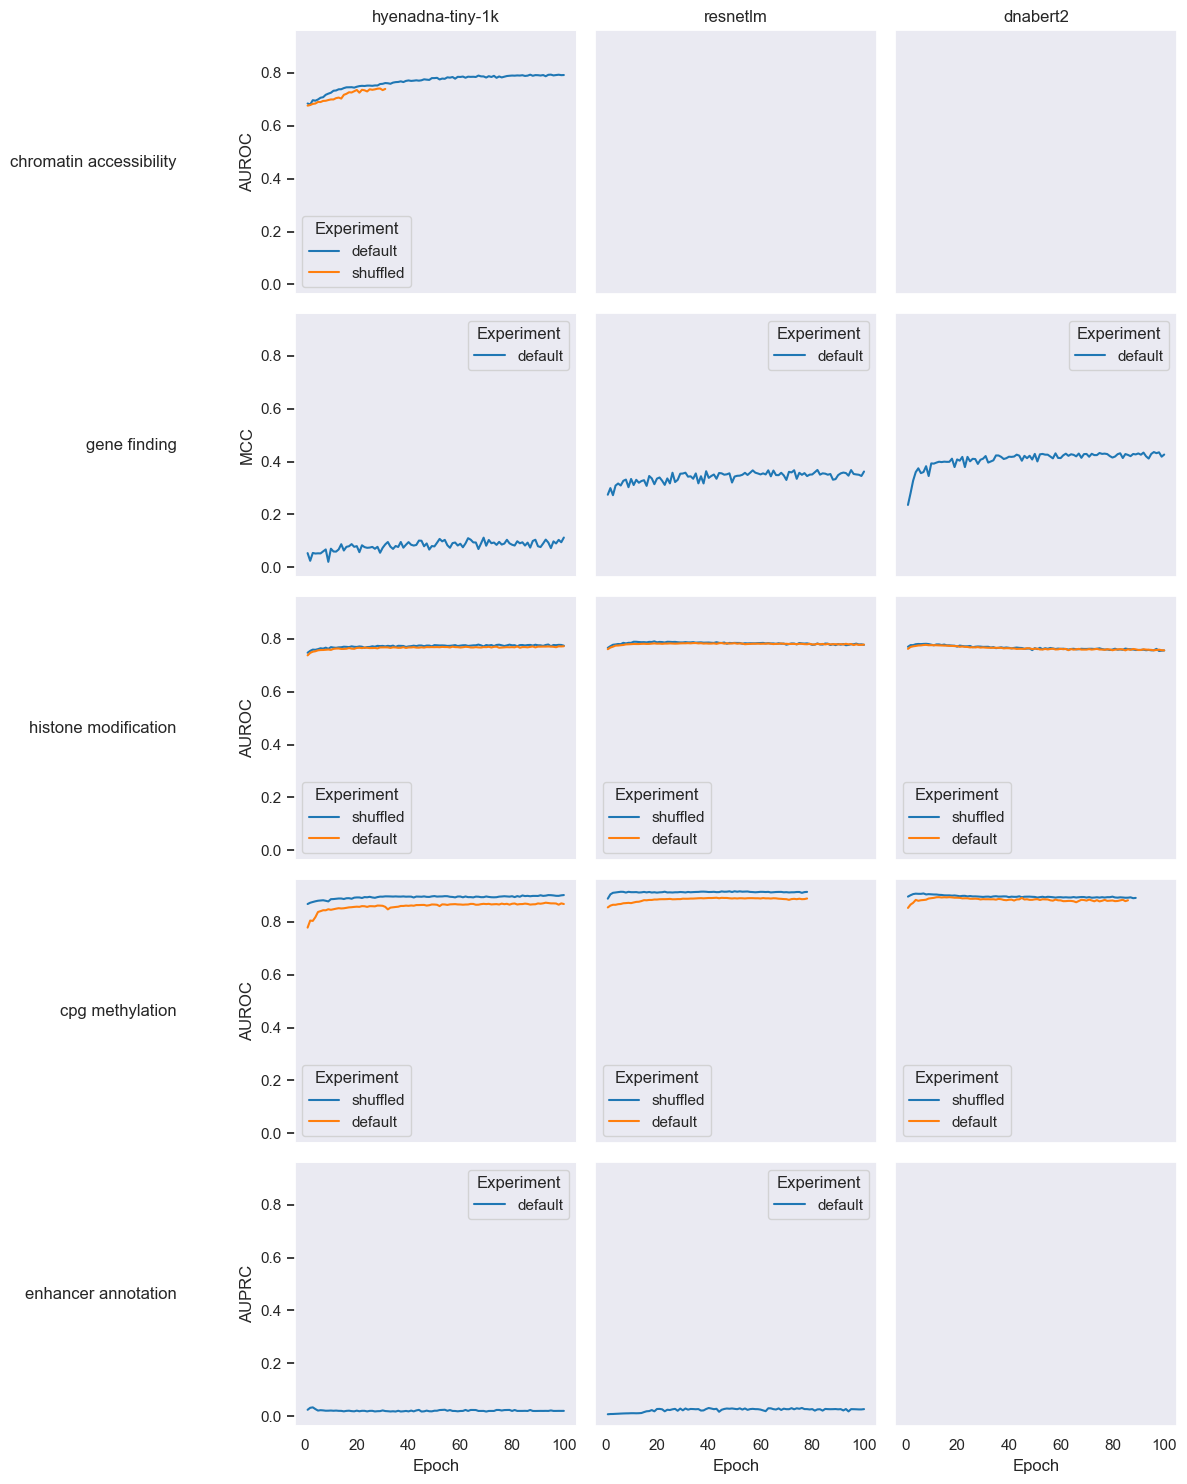

In [102]:
plot_all_auroc_curves(df_losses)

## CpG Methylation

In [329]:
df_cpg = df_losses[df_losses['Task'] == 'cpg methylation']
df_cpg

,Epoch,train_loss,val_loss,val_auroc,training_time,Task,Experiment,Model
300,1,0.273666,0.265990,0.887118,11185.061165,cpg methylation,shuffled,resnetlm
301,2,0.252986,0.254817,0.903391,11017.207081,cpg methylation,shuffled,resnetlm
302,3,0.240614,0.244107,0.909345,11003.908748,cpg methylation,shuffled,resnetlm
303,4,0.234398,0.243757,0.910577,11221.629020,cpg methylation,shuffled,resnetlm
304,5,0.230006,0.241715,0.911931,10937.400368,cpg methylation,shuffled,resnetlm
...,...,...,...,...,...,...,...,...
1013,41,0.216024,0.305641,0.883614,9489.972729,cpg methylation,default,dnabert2
1014,42,0.215104,0.312850,0.880016,9324.824975,cpg methylation,default,dnabert2
1015,43,0.215004,0.304948,0.884210,9374.384868,cpg methylation,default,dnabert2
1016,44,0.214592,0.304536,0.884516,9522.844662,cpg methylation,default,dnabert2


/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_13311/3212475179.py:29: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_model, x='Epoch', y='train_loss', hue='Experiment', palette=palette, ax=ax[idx,0])
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_13311/3212475179.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_model, x='Epoch', y='val_loss', hue='Experiment', palette=palette, ax=ax[idx,1])
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_13311/3212475179.py:29: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_model, x='Epoch', y='train_loss', hue='Experiment', palette=palette, ax=ax[idx,0])
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_13311/3212475179.py:30: UserWarning: The palette list has more values (10) than needed (2),

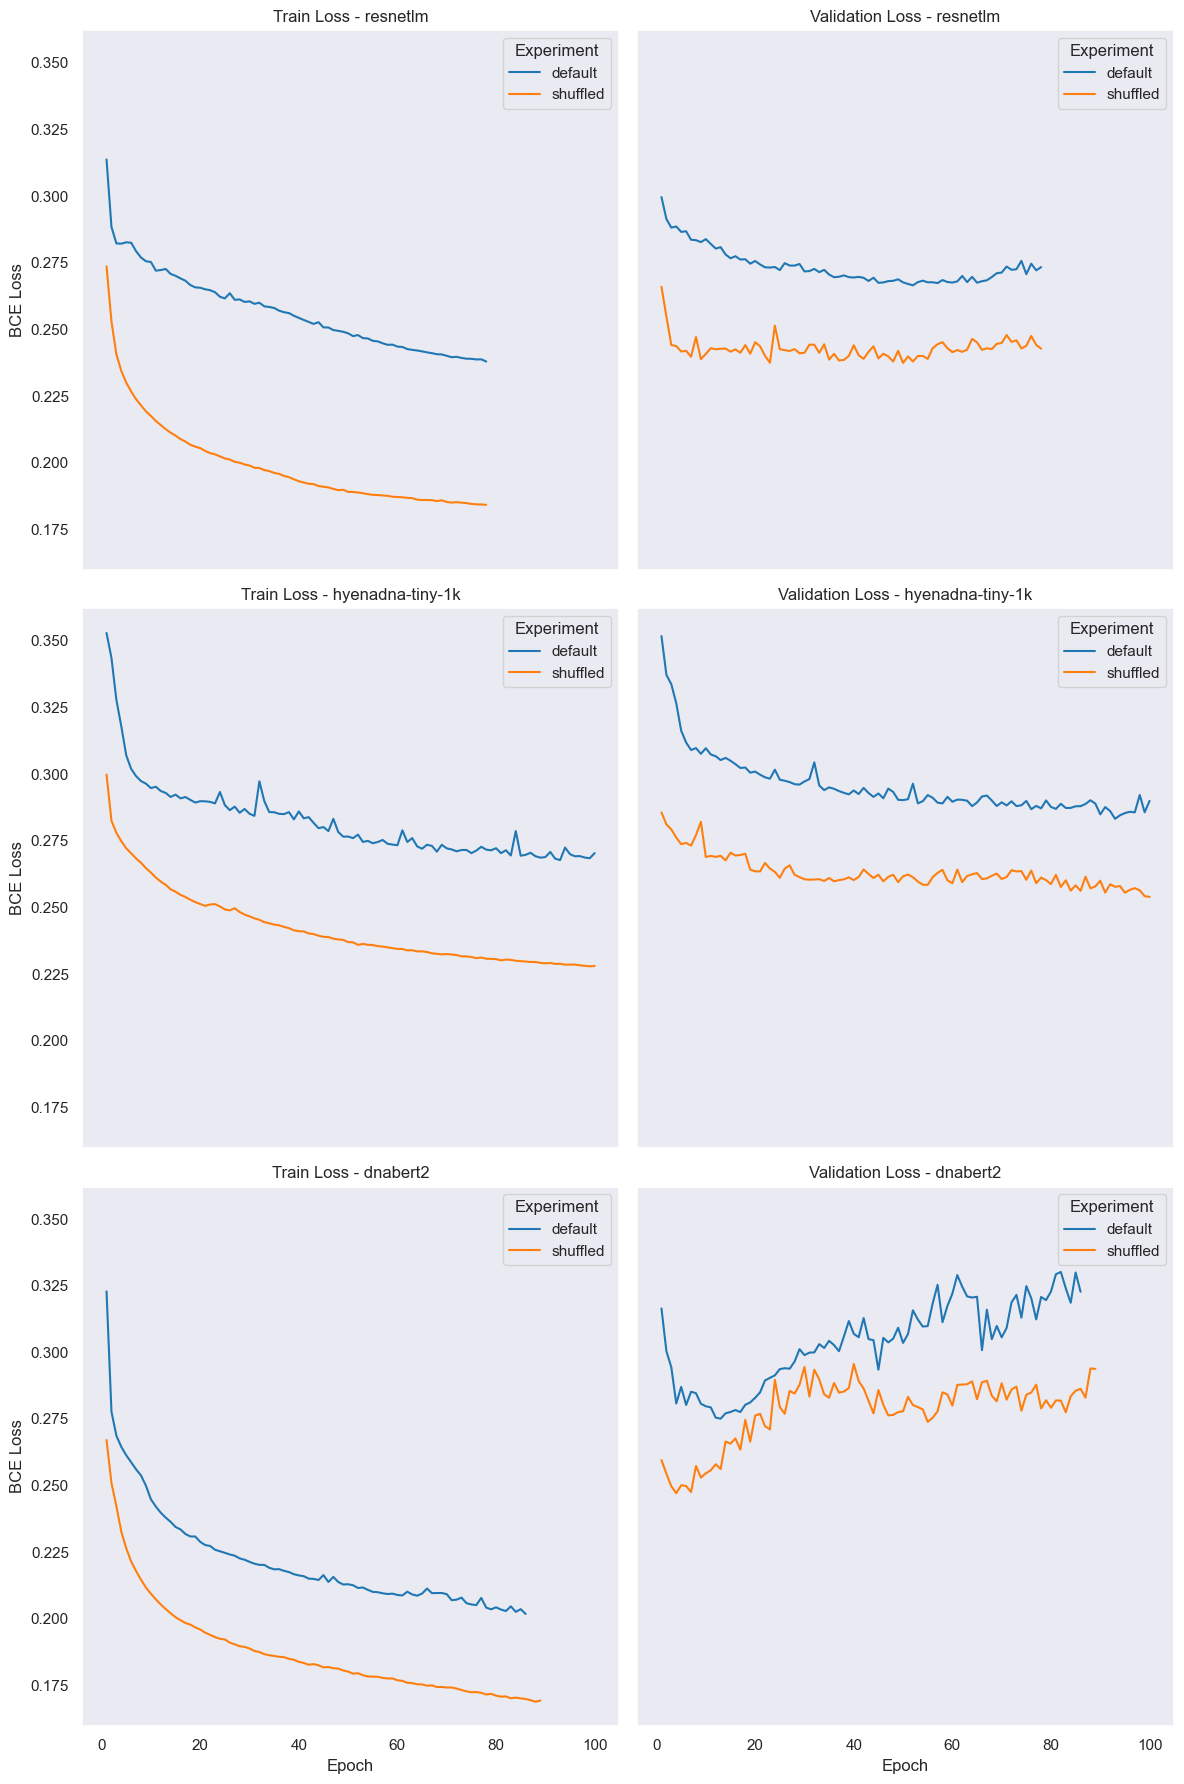

In [103]:
fig = plot_loss_curves(df_cpg)

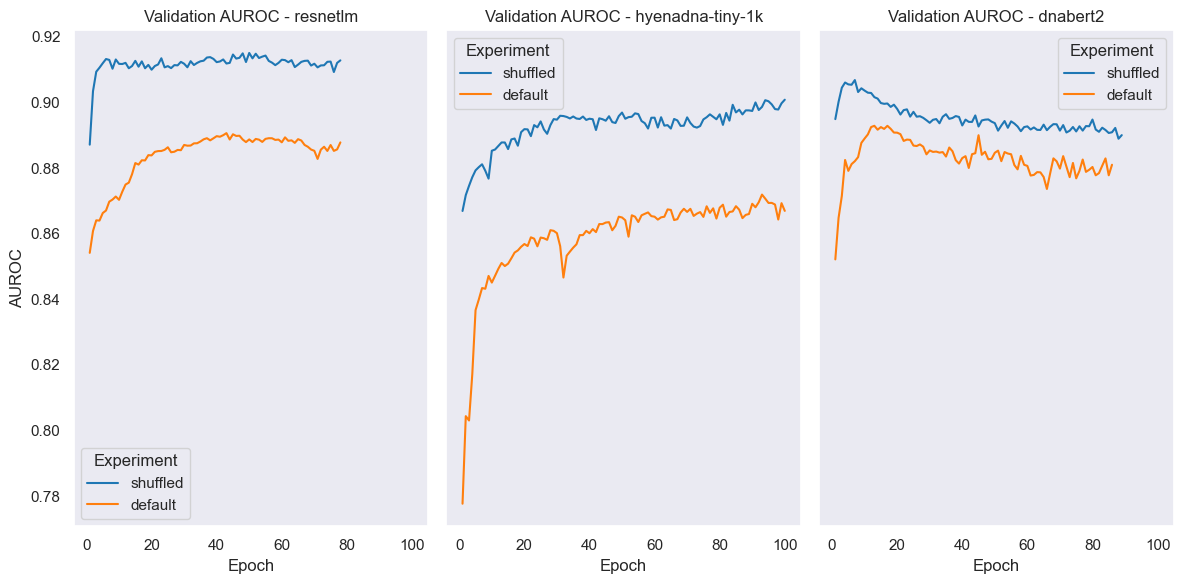

In [104]:
fig = plot_auroc_curves(df_cpg)

## Histone Modification

In [332]:
df_losses_histone = df_losses[df_losses['Task'] == 'histone modification']
df_tests_histone = df_tests[df_tests['Task'] == 'histone modification']

/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_13311/3212475179.py:29: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_model, x='Epoch', y='train_loss', hue='Experiment', palette=palette, ax=ax[idx,0])
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_13311/3212475179.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_model, x='Epoch', y='val_loss', hue='Experiment', palette=palette, ax=ax[idx,1])
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_13311/3212475179.py:29: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_model, x='Epoch', y='train_loss', hue='Experiment', palette=palette, ax=ax[idx,0])
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_13311/3212475179.py:30: UserWarning: The palette list has more values (10) than needed (2),

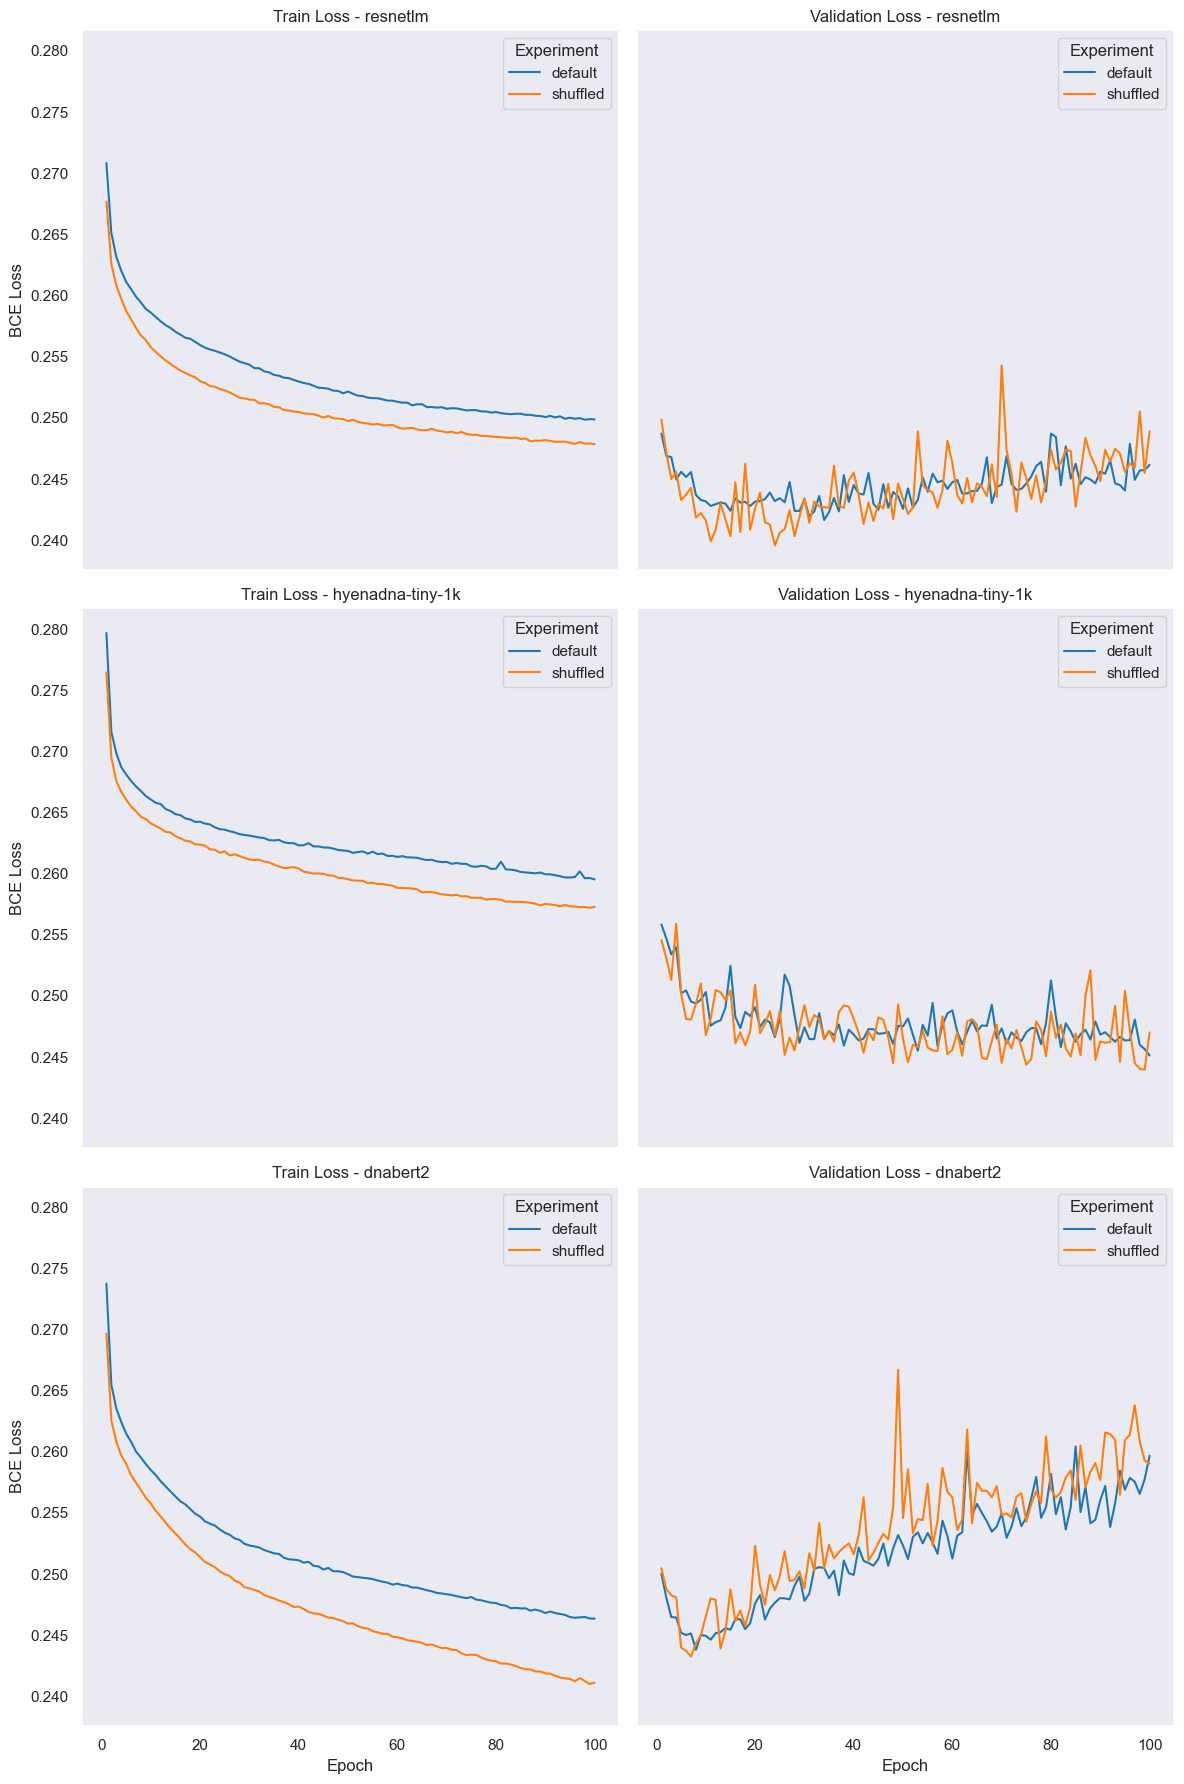

In [105]:
fig = plot_loss_curves(df_losses_histone)
# plt.suptitle(f'Train and Validation Losses of HyneaDNA-tiny-1k on CpG Methylation Task')
# plt.savefig(f'losses_{MODEL}.png', dpi=300)

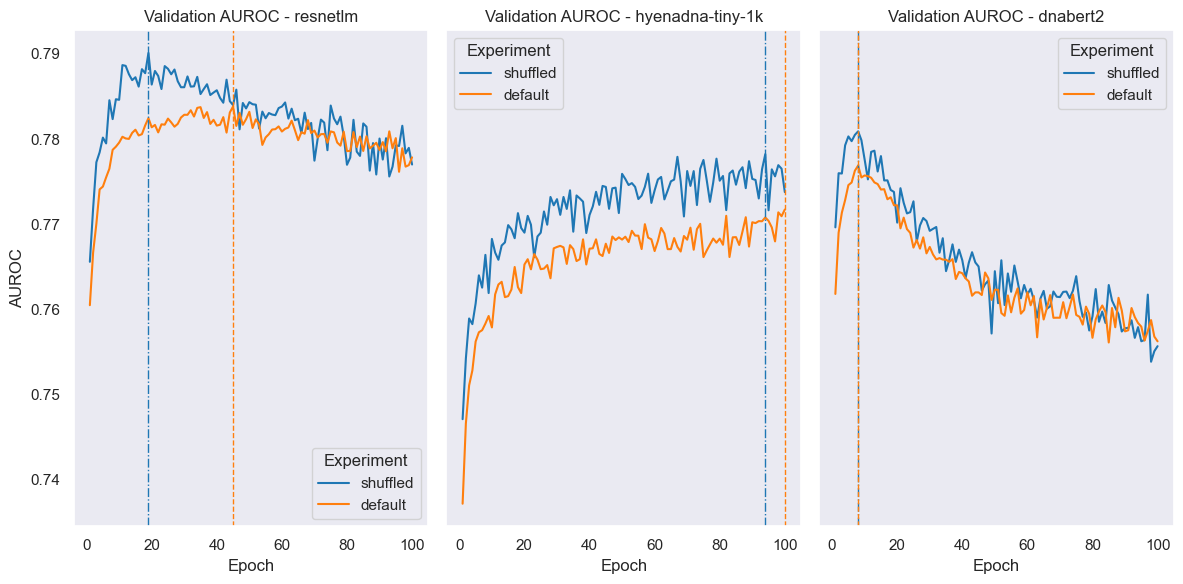

In [106]:
fig = plot_auroc_curves(df_losses_histone, df_tests_histone)
# plt.title(f'Validation AUROC of HyneaDNA-tiny-1k on CpG Methylation Task')
# plt.savefig(f'val_AUROC_{MODEL}.png', dpi=300)

In [335]:
print_test_results(df_tests_histone)

| Task                 | Experiment   | Model            |   Epoch |   test_loss |   test_auroc_avg |
|:---------------------|:-------------|:-----------------|--------:|------------:|-----------------:|
| histone modification | shuffled     | resnetlm         |  19.000 |       0.255 |            0.785 |
| histone modification | default      | resnetlm         |  45.000 |       0.255 |            0.780 |
| histone modification | shuffled     | dnabert2         |   8.000 |       0.256 |            0.776 |
| histone modification | default      | dnabert2         |   8.000 |       0.257 |            0.773 |
| histone modification | shuffled     | hyenadna-tiny-1k |  94.000 |       0.257 |            0.772 |
| histone modification | default      | hyenadna-tiny-1k | 100.000 |       0.258 |            0.766 |


## Training Times

/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_8730/315094492.py:6: UserWarning: The palette list has more values (12) than needed (4), which may not be intended.
  sns.barplot(data=df_losses, x='Model', y='training_time_hours', hue='Group', palette=sns.color_palette('Paired'))


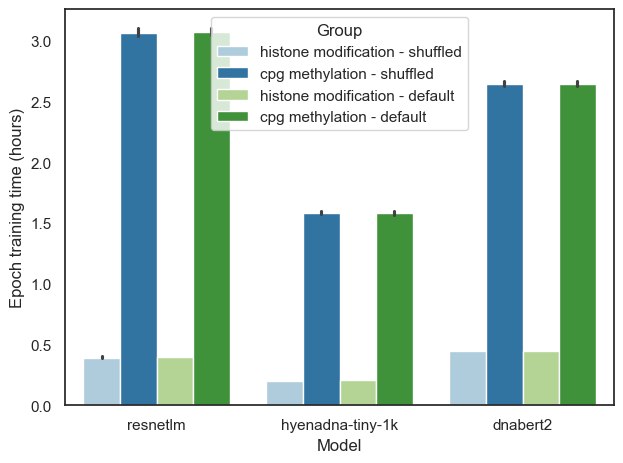

In [ ]:
df_losses['training_time_mins'] = df_losses['training_time']/60
df_losses['training_time_hours'] = df_losses['training_time_mins']/60

df_losses['Group'] = df_losses['Task'] + ' - ' + df_losses['Experiment']
sns.barplot(data=df_losses, x='Model', y='training_time_hours', hue='Group', palette=sns.color_palette('Paired'))

plt.ylabel('Epoch training time (hours)')
plt.tight_layout()
# plt.show()

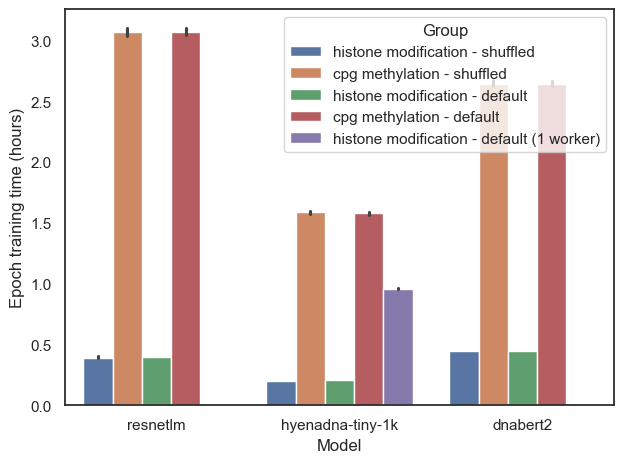

In [368]:
df_losses_all = pd.concat([df_losses, df_losses_hyenadna[df_losses_hyenadna['Experiment'] == 'default (1 worker)']])

df_losses_all['training_time_hours'] = df_losses_all['training_time']/(60*60)


df_losses_all['Group'] = df_losses_all['Task'] + ' - ' + df_losses_all['Experiment']
sns.barplot(data=df_losses_all, x='Model', y='training_time_hours', hue='Group')

plt.ylabel('Epoch training time (hours)')
plt.tight_layout()

## Histone HyenaDNA

The Histone DNA task uses 32 workers as default, which impact the level of shufflying.
Hence, we run the histone modification task using 1 worker and the hyenadna-tiny-1k model.

Text(0.5, 0.98, 'Train and Validation Losses of HyneaDNA-tiny-1k on Histone Modification Task')

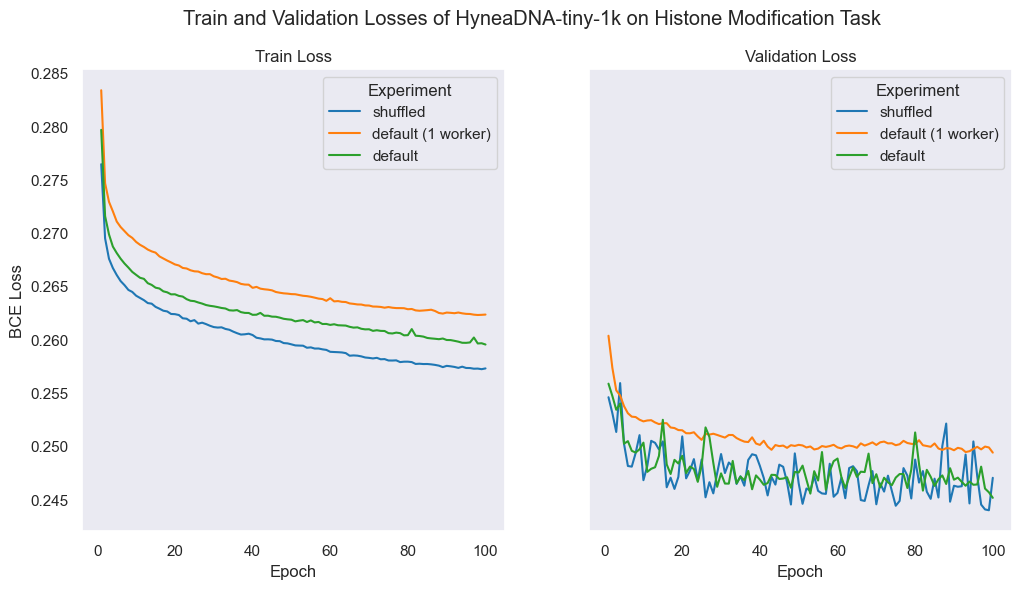

In [107]:
df_hyenadna = df_losses_hyenadna[df_losses_hyenadna['Task'] == 'histone modification']

fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=False, sharey=True)

sns.lineplot(data=df_hyenadna, x='Epoch', y='train_loss', hue='Experiment', ax=ax[0])
sns.lineplot(data=df_hyenadna, x='Epoch', y='val_loss', hue='Experiment', ax=ax[1])
ax[0].set(title='Train Loss', ylabel='BCE Loss')
ax[1].set(title='Validation Loss')
plt.suptitle(f'Train and Validation Losses of HyneaDNA-tiny-1k on Histone Modification Task')

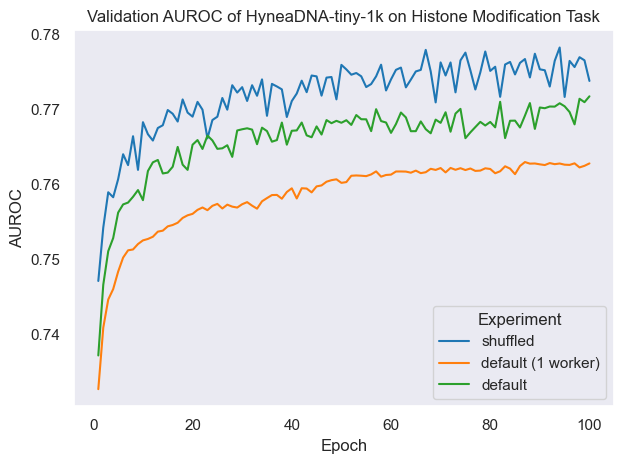

In [108]:
sns.lineplot(data=df_hyenadna, x='Epoch', y='val_auroc', hue='Experiment')

plt.ylabel('AUROC')
plt.title(f'Validation AUROC of HyneaDNA-tiny-1k on Histone Modification Task')
plt.tight_layout()

In [349]:
print_test_results(df_tests_hyenadna)

| Task                 | Experiment         | Model            |   Epoch |   test_loss |   test_auroc_avg |
|:---------------------|:-------------------|:-----------------|--------:|------------:|-----------------:|
| histone modification | shuffled           | hyenadna-tiny-1k |  94.000 |       0.257 |            0.772 |
| histone modification | default            | hyenadna-tiny-1k | 100.000 |       0.258 |            0.766 |
| histone modification | default (1 worker) | hyenadna-tiny-1k |  87.000 |       0.263 |            0.756 |
